# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 2 hours**. For this time interval, using the values of the **4 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train a Boosting model for the task. Choose the model based on the number, and type of features available.**



Features:

* Date: Time window of ten minutes.
* Temperature: Weather Temperature.
* Humidity: Weather Humidity.
* WindSpeed: Wind Speed.
* GeneralDiffuseFlows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DiffuseFlows

Target:

SolarPower

## Dataset links:
* [DS1](https://drive.google.com/file/d/1-Pcpb1xWpKc8Cgs-P7xqBFHw2NM0dBsA/view?usp=sharing)
* [DS2](https://drive.google.com/file/d/1-Pul07w6LXpm-uo99qbNc86FHhwl4yQD/view?usp=sharing)

In [92]:
# conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# Anything above 2.10 is not supported on the GPU on Windows Native# Verify the installation:
# python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
!pip install tensorflow-cpu

ERROR: Could not find a version that satisfies the requirement tensorflow-cpu (from versions: none)
ERROR: No matching distribution found for tensorflow-cpu


In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import Input, LSTM, Dense

## Read the datasets

In [94]:
df1 = pd.read_csv("https://raw.githubusercontent.com/MilenaTrajanoska/vnp-24-25/refs/heads/main/Decision%20trees%20%26%20XGBoost/power_consumption_g3.csv")

In [95]:
df2 = pd.read_csv("https://raw.githubusercontent.com/MilenaTrajanoska/vnp-24-25/refs/heads/main/Decision%20trees%20%26%20XGBoost/power_consumption_g3_feat.csv")

## Merge the datasets (and pre-processing if needed)

In [96]:
df = pd.merge(df1, df2, on='Date')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [97]:
df.sort_index(inplace=True)

In [98]:
df

,SolarPower,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
Date,,,,,,
2017-01-01 00:00:00,34055.69620,6.559,73.8,0.083,0.051,0.119
2017-01-01 00:10:00,29814.68354,6.414,74.5,0.083,0.070,0.085
2017-01-01 00:20:00,29128.10127,6.313,74.5,0.080,0.062,0.100
2017-01-01 00:30:00,28228.86076,6.121,75.0,0.083,0.091,0.096
2017-01-01 00:40:00,27335.69620,5.921,75.7,0.081,0.048,0.085
...,...,...,...,...,...,...
2017-12-30 23:10:00,31160.45627,7.010,72.4,0.080,NaN,0.096
2017-12-30 23:20:00,30430.41825,6.947,72.6,0.082,0.051,0.093
2017-12-30 23:30:00,29590.87452,6.900,72.8,0.086,0.084,0.074


In [99]:
df.isnull().sum()

SolarPower               0
Temperature            559
Humidity               499
WindSpeed              529
GeneralDiffuseFlows    524
DiffuseFlows           505
dtype: int64

In [100]:
df = df.ffill().bfill()

In [101]:
df.isnull().sum()

SolarPower             0
Temperature            0
Humidity               0
WindSpeed              0
GeneralDiffuseFlows    0
DiffuseFlows           0
dtype: int64

## Group the datasets into time intervals of 2 hours

In [102]:
copy = df.resample("2h").mean()

In [103]:
df = copy

## Create lags

In [104]:
lags = 3

periods = range(lags, 0, -1)
periods

range(3, 0, -1)

In [111]:
c = df.shift(periods=periods)

In [114]:
df = pd.concat([df, c], axis=1)

In [113]:
c

,SolarPower_3,Temperature_3,Humidity_3,WindSpeed_3,GeneralDiffuseFlows_3,DiffuseFlows_3,SolarPower_2,Temperature_2,Humidity_2,WindSpeed_2,GeneralDiffuseFlows_2,DiffuseFlows_2,SolarPower_1,Temperature_1,Humidity_1,WindSpeed_1,GeneralDiffuseFlows_1,DiffuseFlows_1
Date,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26927.594937,5.878500,76.283333,0.081917,0.060167,0.105667
2017-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,26927.594937,5.878500,76.283333,0.081917,0.060167,0.105667,21447.088607,5.029333,78.008333,0.082583,0.061417,0.135083
2017-01-01 06:00:00,26927.594937,5.878500,76.283333,0.081917,0.060167,0.105667,21447.088607,5.029333,78.008333,0.082583,0.061417,0.135083,20641.518987,4.919667,74.641667,0.081667,0.061917,0.120833
2017-01-01 08:00:00,21447.088607,5.029333,78.008333,0.082583,0.061417,0.135083,20641.518987,4.919667,74.641667,0.081667,0.061917,0.120833,20094.683545,4.512750,74.575000,0.082417,0.063583,0.122500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 14:00:00,23720.152091,11.082500,48.224167,0.078083,76.933417,16.660000,29649.683142,13.382500,43.325000,0.077000,353.441667,36.275833,30490.240812,14.399167,38.129167,0.077667,489.841667,38.455000
2017-12-30 16:00:00,29649.683142,13.382500,43.325000,0.077000,353.441667,36.275833,30490.240812,14.399167,38.129167,0.077667,489.841667,38.455000,29293.789606,14.513333,39.655833,0.077667,409.650000,42.163333
2017-12-30 18:00:00,30490.240812,14.399167,38.129167,0.077667,489.841667,38.455000,29293.789606,14.513333,39.655833,0.077667,409.650000,42.163333,31262.864386,14.015000,43.096667,0.077500,153.905000,152.368333


In [115]:
df.dropna(axis=0, inplace=True)

In [117]:
df.head(2)

,SolarPower,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower_3,Temperature_3,Humidity_3,WindSpeed_3,...,Humidity_2,WindSpeed_2,GeneralDiffuseFlows_2,DiffuseFlows_2,SolarPower_1,Temperature_1,Humidity_1,WindSpeed_1,GeneralDiffuseFlows_1,DiffuseFlows_1
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 06:00:00,20094.683545,4.512750,74.575000,0.082417,0.063583,0.122500,26927.594937,5.878500,76.283333,0.081917,...,78.008333,0.082583,0.061417,0.135083,20641.518987,4.919667,74.641667,0.081667,0.061917,0.120833
2017-01-01 08:00:00,21255.189872,4.632167,73.791667,0.082417,79.281917,15.761833,21447.088607,5.029333,78.008333,0.082583,...,74.641667,0.081667,0.061917,0.120833,20094.683545,4.512750,74.575000,0.082417,0.063583,0.122500


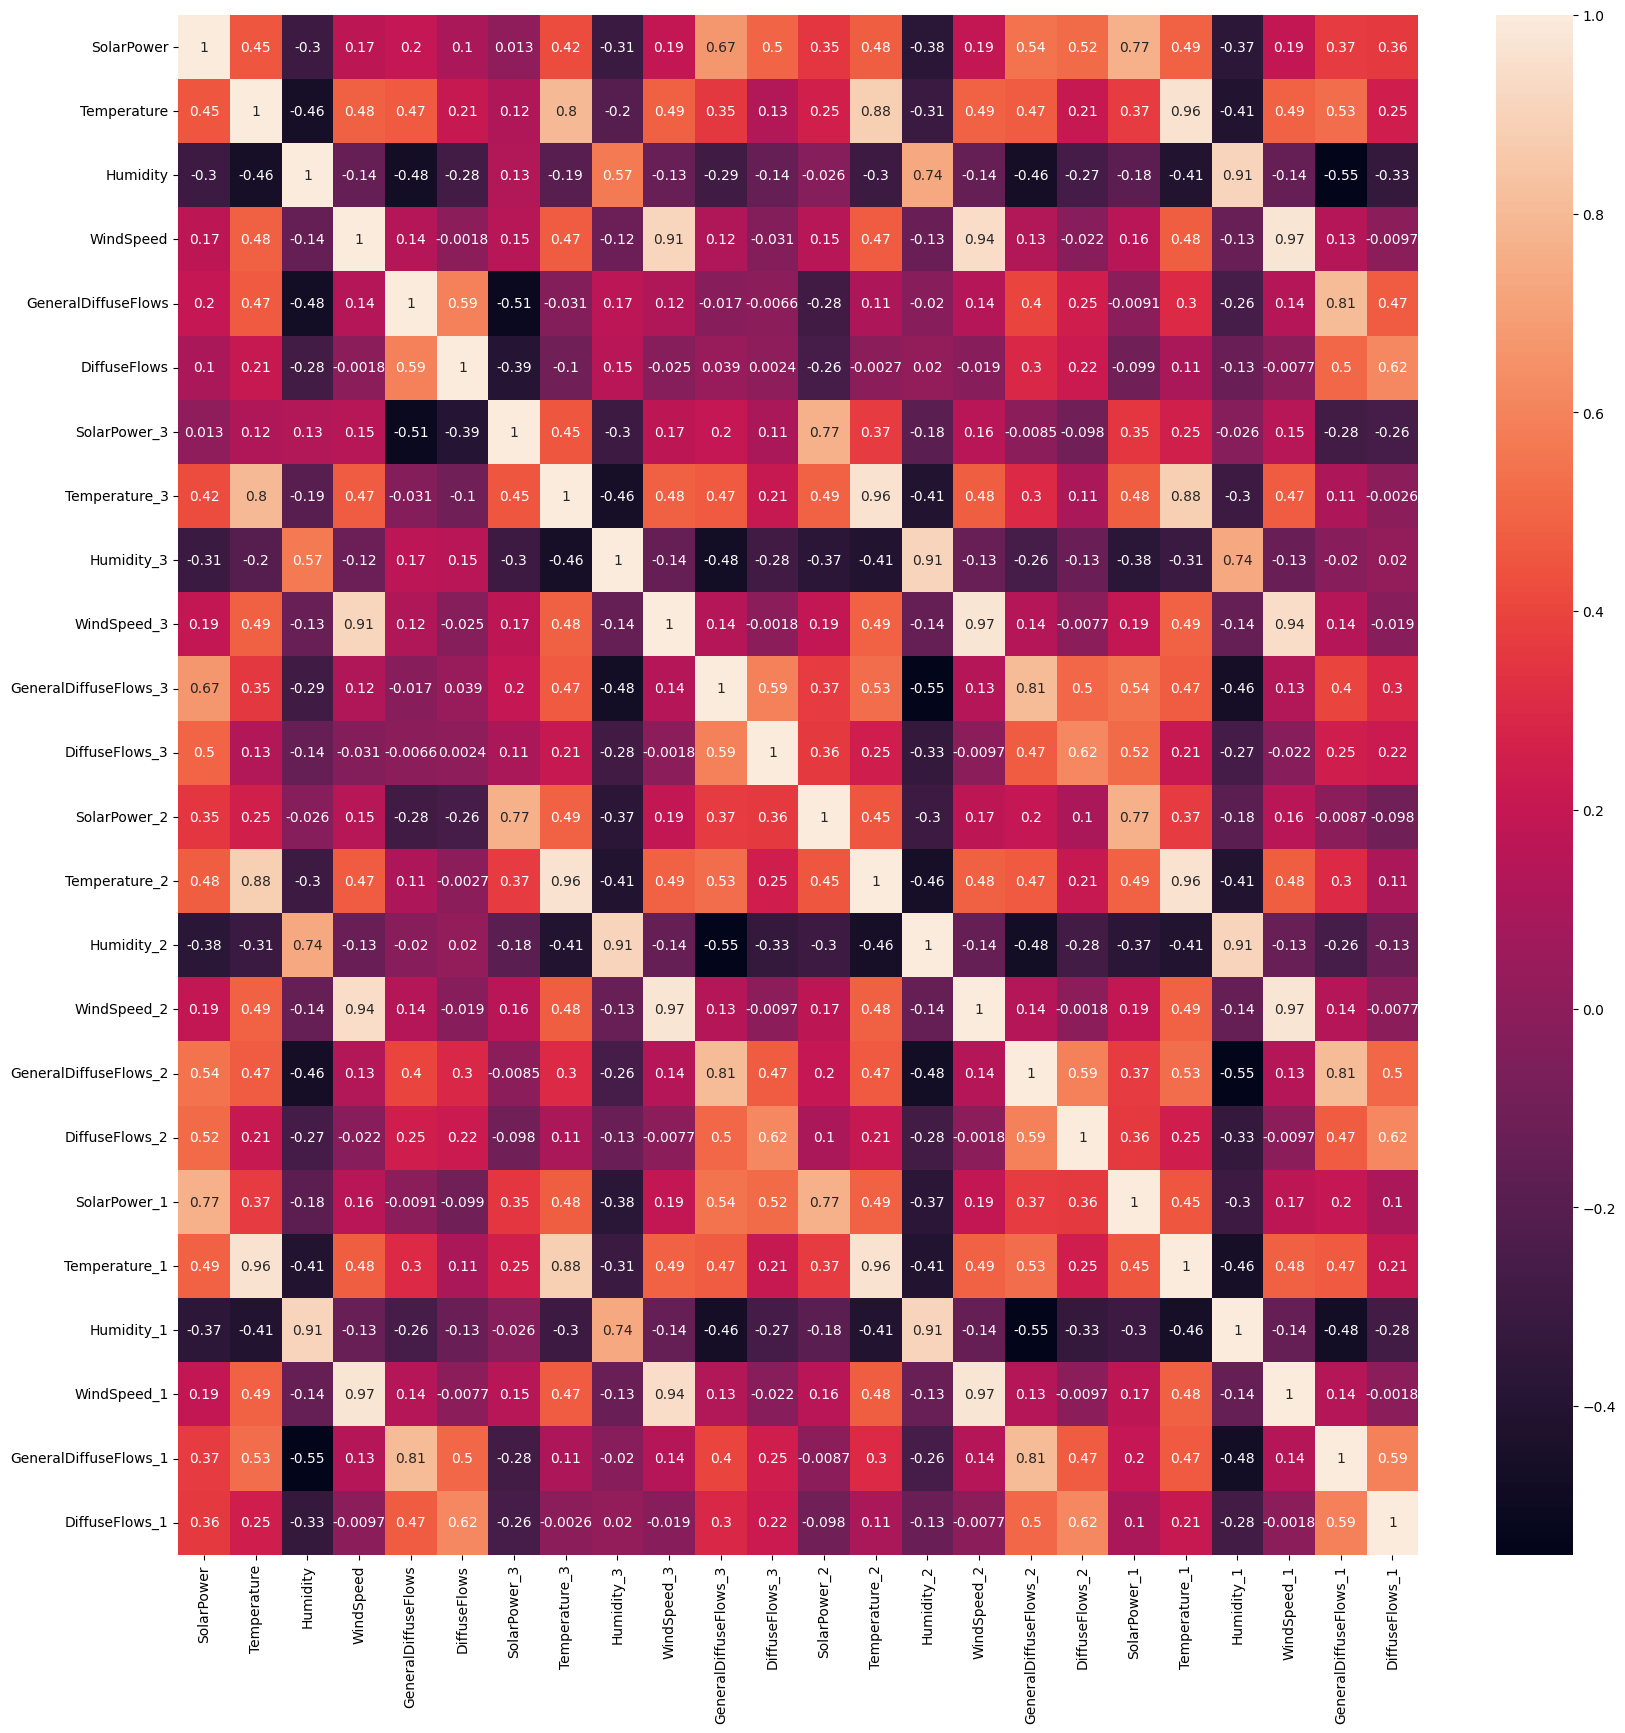

In [118]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)
plt.show()

# Split the dataset into 80% training and 20% testing datasets

In [121]:
X, y = df[['SolarPower_1', 'SolarPower_2', 'SolarPower_3']], df['SolarPower']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

In [124]:
# based on the features i am going to use XGBoost because it best handles big datasets!abs
from xgboost import XGBRegressor

## Create the model, pre-process the data and make it suitable for training

In [125]:
xgb = XGBRegressor()
xgb.fit(train_X, train_y)

pred_y = xgb.predict(test_X)

print(r2_score(test_y, pred_y))

0.7922325739429921


## Perform hyper-parameter optimization with a 5-fold cross validation.

Important: Do not use many values for the hyper-parameters due to time constraints.

KEEP IN MIND THE DATASET IS TIME-SERIES.

In [127]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 700],
    'learning_rate': [0.1, 0.01, 0.05]
}
gc = GridSearchCV(estimator=xgb, param_grid=params, cv=5)
gc.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...ne,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 700]})

## Fit the model with the best parameters on the training dataset

In [131]:
model = gc.best_estimator_
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

## Calculate the adequate metrics on the testing dataset

In [132]:
print(r2_score(test_y, pred_y))

0.7926862564903043


## Visualize the targets against the predictions

In [133]:
import os
print(os.getcwd())

C:\Users\Artan\Desktop\Data_Science\vnp-24-25\Decision trees & XGBoost
